In [1]:
import numpy as np
import cv2
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# **READ DATA**

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

BATCH_SIZE=120
IMG_SIZE=(48,48)
SEED=11
VALIDATION_SPLIT=0.2

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE, 
                                                                 #validation_split=VALIDATION_SPLIT,
                                                                 label_mode='categorical',
                                                                 #subset='training',
                                                                 color_mode='grayscale')
# val_data = tf.keras.utils.image_dataset_from_directory(train_dir,
#                                                                  shuffle=True,
#                                                                  seed=SEED,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  image_size=IMG_SIZE, 
#                                                                  validation_split=VALIDATION_SPLIT,
#                                                                  label_mode='categorical',
#                                                                  subset='validation',
#                                                                  color_mode='grayscale')
val_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 shuffle=True,
                                                                 seed=SEED,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode='categorical',
                                                                 color_mode='grayscale')

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


# **EDA**

**PLOT DATA SAMPLE**

Class name:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of class:  7


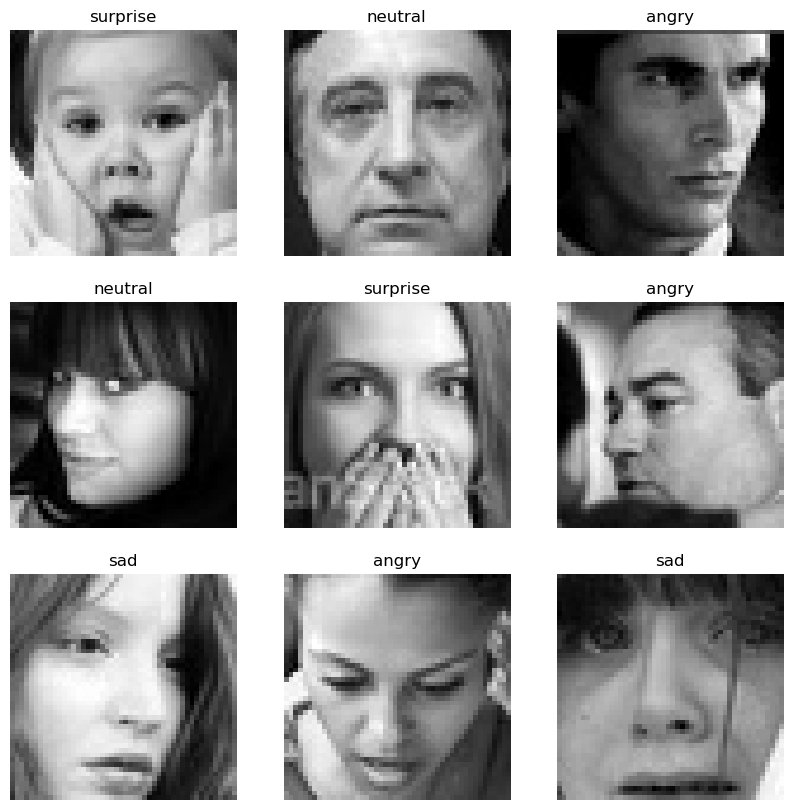

In [3]:
class_names = train_data.class_names
print('Class name: ',class_names)
num_classes=len(class_names)
print('Number of class: ',num_classes)

plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"),cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

**CLASS DISTRIBUTION**

Text(0.5, 1.0, 'Labels Distribution')

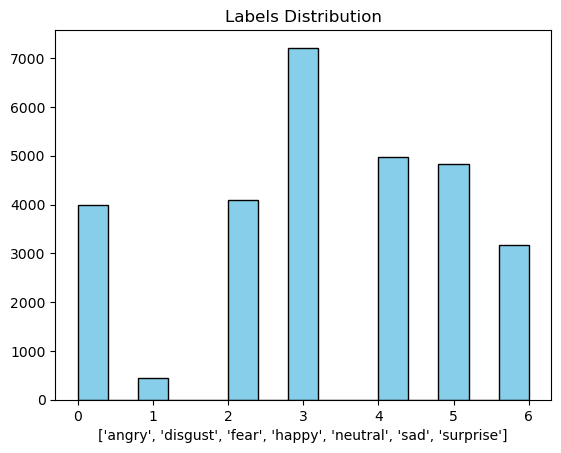

In [4]:
labels_first = []
for batch in train_data:
    _, label = batch  # Assuming the labels are in the second position of each batch
    labels_first.extend(label.numpy())  # Append labels to the list
# Plot the histogram
plt.hist(np.argmax(labels_first,axis=1), bins=15, color='skyblue', edgecolor='black') 
plt.xlabel(class_names)
plt.title('Labels Distribution')

**REMOVE HIGH AND LOW CONTRAST IMAGE**

In [5]:
# Extract the images and labels from the generator1
filtered_images = []
filtered_labels = []
disgust_data = []
disgust_label = []
filtered_high_images = []
filtered_high_labels = []
filtered_low_images = []
filtered_low_labels = []
        
print('extract image')
for images, labels in train_data: 
    for j in range(images.shape[0]):
        image_contrast = np.mean(images[j])
        if image_contrast > 229:
            filtered_high_images.append(images[j])
            filtered_high_labels.append(labels[j])
        elif image_contrast < 25:
            filtered_low_images.append(images[j])
            filtered_low_labels.append(labels[j])
        elif image_contrast >= 25 and image_contrast <= 229:
            if labels[j][1] != 1:
                filtered_images.append(images[j])
                filtered_labels.append(labels[j])
            elif labels[j][1] == 1:
                disgust_data.append(images[j])
                disgust_label.append(labels[j])
                
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)
filtered_high_images = np.array(filtered_high_images)
filtered_high_labels = np.array(filtered_high_labels)
filtered_low_images = np.array(filtered_low_images)
filtered_low_labels = np.array(filtered_low_labels)
disgust_data = np.array(disgust_data)
disgust_label = np.array(disgust_label)

print('length filtered_images', len(filtered_images))
print('length disgust_data', len(disgust_data))
print('length filtered_high_images', len(filtered_high_images))
print('length filtered_low_images', len(filtered_low_images))

extract image
length filtered_images 28228
length disgust_data 435
length filtered_high_images 23
length filtered_low_images 23


In [6]:
# from imblearn.over_sampling import RandomOverSampler
# print('extract')
# filtered_images = []
# filtered_labels = []
# filtered_high_images = []
# filtered_high_labels = []
# filtered_low_images = []
# filtered_low_labels = []

# for images, labels in train_data: 
#     for j in range(images.shape[0]):
#         image_contrast = np.mean(images[j])
#         if image_contrast > 229:
#             filtered_high_images.append(images[j])
#             filtered_high_labels.append(labels[j])
#         elif image_contrast < 25:
#             filtered_low_images.append(images[j])
#             filtered_low_labels.append(labels[j])
#         elif image_contrast >= 25 and image_contrast <= 229:
#             filtered_images.append(images[j])
#             filtered_labels.append(labels[j])

# print('done')

# filtered_images = np.array(filtered_images)
# filtered_labels = np.array(filtered_labels)
# filtered_high_images = np.array(filtered_high_images)
# filtered_high_labels = np.array(filtered_high_labels)
# filtered_low_images = np.array(filtered_low_images)
# filtered_low_labels = np.array(filtered_low_labels)

# print(len(filtered_images))


# print('oversample')
# n_samples = filtered_images.shape[0]
# X_resampled = filtered_images.reshape(n_samples, -1)

# over_sample = RandomOverSampler(random_state=42)
# X_resampled, y_resampled = over_sample.fit_resample(X_resampled, filtered_labels)

# print(X_resampled.shape)
# print(type(X_resampled))


# print('y_resampled', y_resampled)

# X_resampled = X_resampled.reshape(-1, 48, 48, 1)
# print(X_resampled.shape)

# a=np.argmax(y_resampled,axis=1)

# plt.hist(a, bins='auto')
# plt.title('Histogram Distribution')
# plt.ylabel('Frequency')

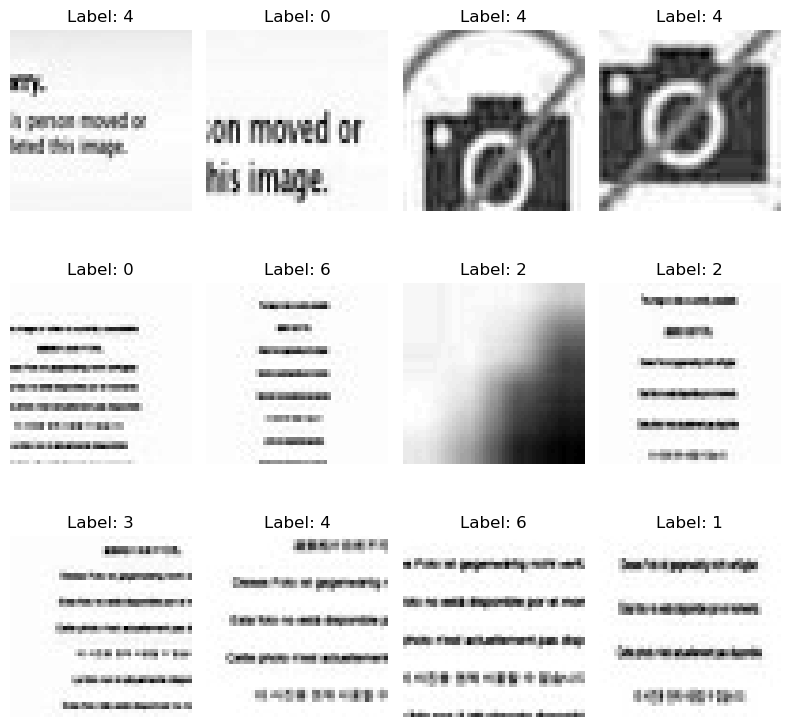

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(filtered_high_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(filtered_high_labels[i])))
    ax.axis('off')

plt.tight_layout()
plt.show()

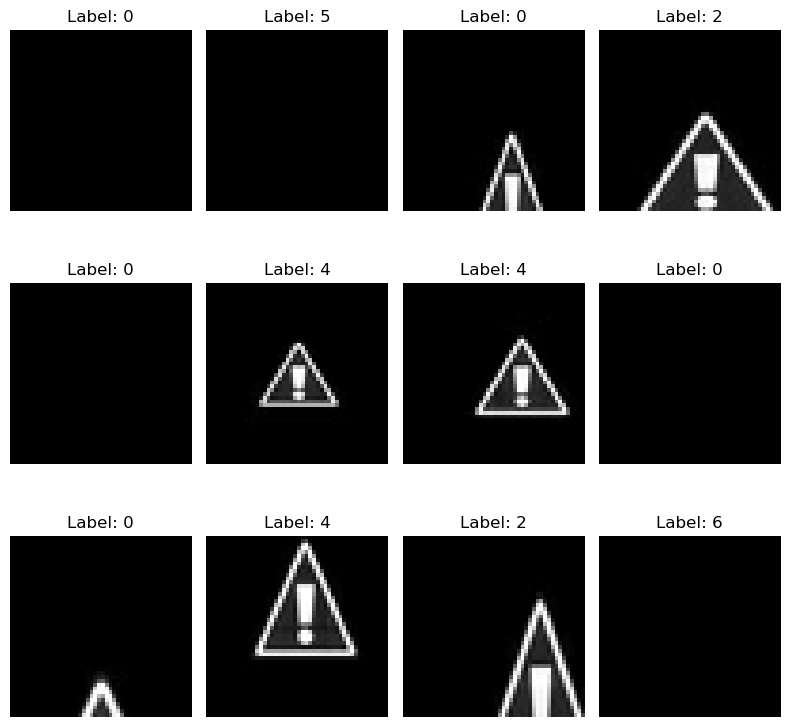

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(filtered_low_images[i], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(filtered_low_labels[i])))
    ax.axis('off')

plt.tight_layout()
plt.show()

**BALANCED DATA FROM CLASS DIGUST**

In [9]:
from skimage import transform, util
import random
# Initialize empty lists to store augmented images and labels
augmented_data = []
augmented_labels = []

# Perform random augmentation for each original image
for i in range(disgust_data.shape[0]):
    image = disgust_data[i]
    label = disgust_label[i]

    # Augment the image multiple times
    for _ in range(2):
        angle = random.randint(-30, 30)
        rotated_image = transform.rotate(image, angle, resize=False)
        flipped_image = np.fliplr(rotated_image)
        augmented_data.append(rotated_image)
        augmented_labels.append(label)
        augmented_data.append(flipped_image)
        augmented_labels.append(label)

# Convert the lists to numpy arrays
augmented_data = np.array(augmented_data)
augmented_labels = np.array(augmented_labels)

# Concatenate the augmented data with the original data
disgust_data_agm = np.concatenate((disgust_data, augmented_data), axis=0)

# Concatenate the augmented labels with the original labels
disgust_labels_agm = np.concatenate((disgust_label, augmented_labels), axis=0)

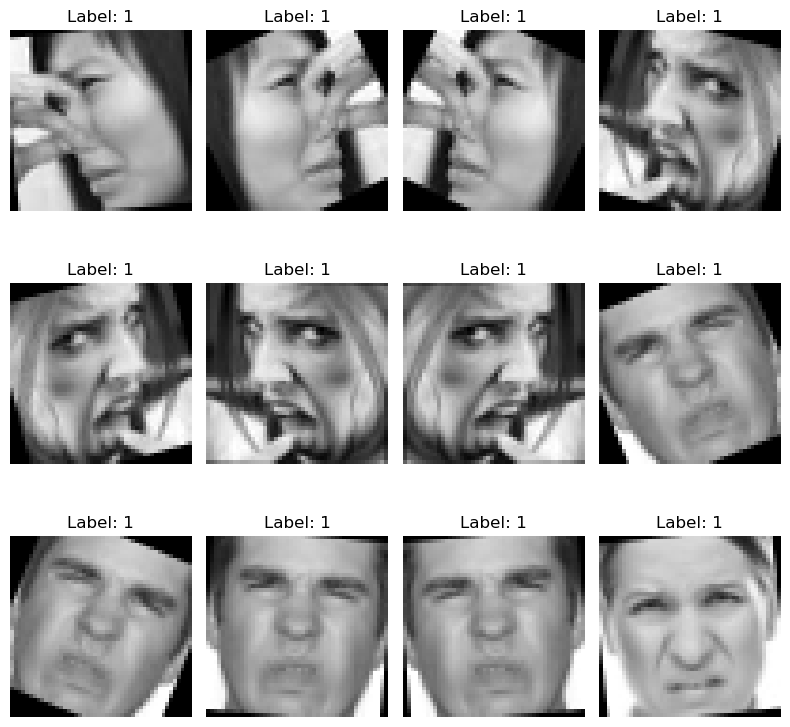

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(disgust_data_agm[i+436], cmap='gray')
    ax.set_title('Label: {}'.format(np.argmax(disgust_labels_agm[i+436])))
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
final_train_data = np.concatenate((filtered_images, disgust_data_agm))
final_train_labels = np.concatenate((filtered_labels, disgust_labels_agm))

Text(0, 0.5, 'Frequency')

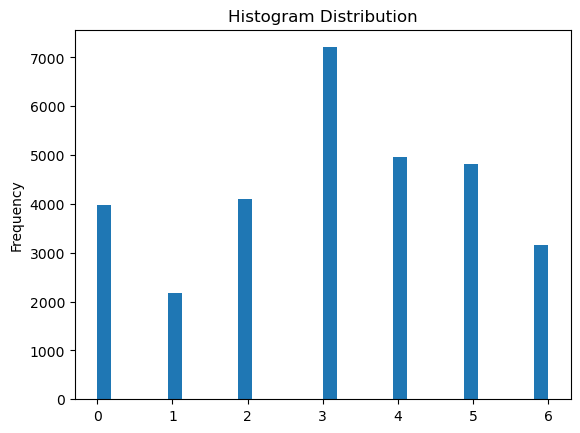

In [12]:
alter_labels=np.argmax(final_train_labels,axis=1)
plt.hist(alter_labels, bins='auto')
plt.title('Histogram Distribution')
plt.ylabel('Frequency')

**DATA AUGMENTAION**

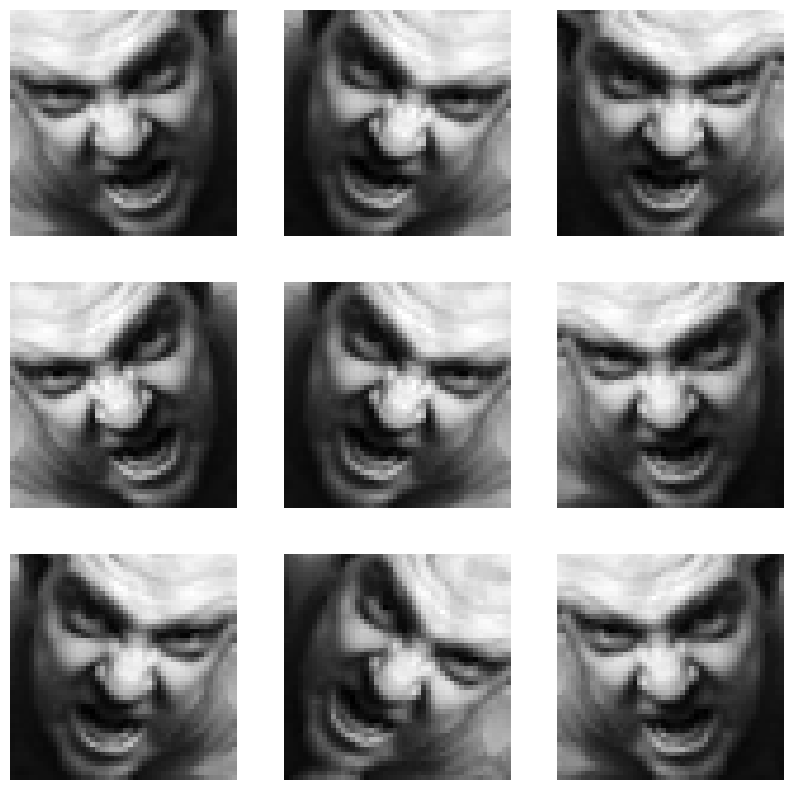

In [13]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.05)
])
for image, _ in train_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0],cmap='gray')
    plt.axis('off')

# **BUILD MODEL**

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)
#test_data = test_data.prefetch(buffer_size=AUTOTUNE)

In [15]:
model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=IMG_SIZE),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

In [16]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        pt = tf.math.exp(-ce_loss)
        focal_loss = alpha * tf.math.pow((1 - pt), gamma) * ce_loss
        return focal_loss
    return focal_loss_fixed

In [17]:
reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor= 0.5,
    patience=7,
    verbose=1,
    mode="max",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-7
)

In [18]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',       #focal_loss(gamma=2.0, alpha=0.25), 
    metrics=["accuracy"]
    
)

# **RUNNING MODEL**

In [19]:
num_epochs = 80
class_weights = {
            0:1.02660468,
            1:9.40661861,
            2:1.00104606,
            3:0.56843877,
            4:0.84912748,
            5:1.29337298,
            6:0.82603942,
}

history=model.fit(
    final_train_data,final_train_labels,
    #X_resampled, y_resampled,
    #train_data,
    epochs=num_epochs,
    validation_data=val_data,
    #class_weight=class_weights
    callbacks=[reduce_lr]
)

Epoch 1/80


2023-07-12 15:46:50.771052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


951/951 [==============================] - 32s 24ms/step - loss: 2.7173 - accuracy: 0.1743 - val_loss: 1.9303 - val_accuracy: 0.2542 - lr: 1.0000e-04
Epoch 2/80
951/951 [==============================] - 13s 14ms/step - loss: 2.4223 - accuracy: 0.1934 - val_loss: 1.9020 - val_accuracy: 0.2662 - lr: 1.0000e-04
Epoch 3/80
951/951 [==============================] - 14s 15ms/step - loss: 2.2707 - accuracy: 0.1987 - val_loss: 1.8257 - val_accuracy: 0.2779 - lr: 1.0000e-04
Epoch 4/80
951/951 [==============================] - 13s 14ms/step - loss: 2.1351 - accuracy: 0.2218 - val_loss: 1.7250 - val_accuracy: 0.3162 - lr: 1.0000e-04
Epoch 5/80
951/951 [==============================] - 14s 14ms/step - loss: 2.0245 - accuracy: 0.2489 - val_loss: 1.6623 - val_accuracy: 0.3447 - lr: 1.0000e-04
Epoch 6/80
951/951 [==============================] - 13s 14ms/step - loss: 1.9235 - accuracy: 0.2786 - val_loss: 1.6286 - val_accuracy: 0.3828 - lr: 1.0000e-04
Epoch 7/80
951/951 [=========================

# **EVALUATE MODEL**

**EVALUATE ON TEST SET**

In [20]:
# test_loss, test_acc = model.evaluate(test_data)

# print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_acc:.4f}")

**MODEL HISTORY**

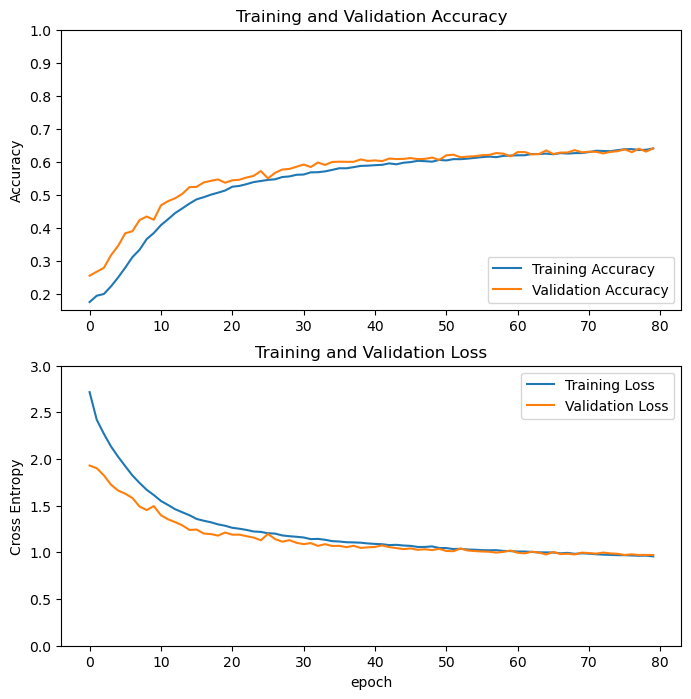

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**CONFUSION MATRIX**

60/60 [==============================] - 3s 40ms/step
FP:  [ 930   83  435 1325 1219 1135  772]     FN:  [ 818  110  954 1328  969 1004  716]     TP:  [140   1  70 446 264 243 115]     TN:  [5290 6984 5719 4079 4726 4796 5575]
F1 Score: 0.178
Precision Score: 0.178
Recall Score: 0.178


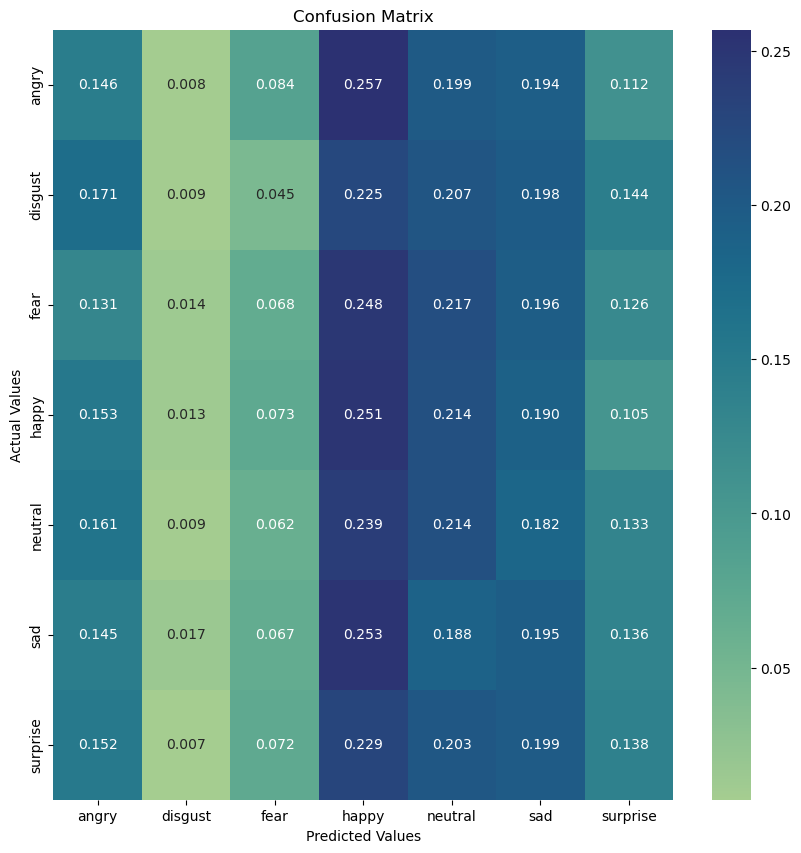

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score
y_pred_probabilities = model.predict(val_data)
y_pred = np.argmax(y_pred_probabilities, axis=1)
y_true = np.concatenate([np.argmax(y,axis=1) for _, y in val_data], axis=0)

# Compute the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)
FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  
FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)
TP = np.diag(confusion_mat)
TN = confusion_mat.sum() - (FP + FN + TP)
print('FP: ',FP,'    FN: ',FN,'    TP: ',TP,'    TN: ',TN)
print('F1 Score: %.3f' % precision_score(y_true, y_pred,average='micro'))
print('Precision Score: %.3f' % f1_score(y_true, y_pred,average='micro'))
print('Recall Score: %.3f' % recall_score(y_true, y_pred,average='micro'))
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,10))
sns.heatmap(confusion_mat_norm, annot=True,cmap="crest",fmt='.3f', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()